In [ ]:
# Добавляем нужные библиотеки
from sklearn.model_selection import train_test_split
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import sklearn
from sklearn.metrics import f1_score, roc_auc_score,ndcg_score
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline


In [ ]:
# загружаем таблицы данных
members_pd = pd.read_csv("members.csv")
songs_pd = pd.read_csv('songs.csv')
sample_pd = pd.read_csv("sample_submission.csv")
tranin_data_pd = pd.read_csv('train.csv')

In [ ]:
#Соеденяем все таблицы в одну
merge_df = pd.merge(tranin_data_pd, members_pd, on="msno", how='inner')
train_df = pd.merge(merge_df, songs_pd, on="song_id", how='inner')

In [8]:
# выделяем числовые данные и категориальные данные
categorical_features = train_df.select_dtypes(include='O').columns
numeric_features = train_df.select_dtypes(include=(np.number)).columns

#Заполняем пробелы в датасете
for col in categorical_features:
    train_df[col] = train_df[col].fillna('UnKnown')
for col in numeric_features:
    train_df[col] = train_df[col].interpolate(method='linear')

In [9]:
# Разбиваем датасет на фичи и таргетные значения
Y_data = train_df["target"]
X_data = train_df.drop(columns="target",axis= 1)
X_data.fillna("0", inplace=True)
X_processed = X_data.copy()

# Применяем Label Encoding к каждому категориальному признаку, чтоб перевести его в числовой
# Автоматически алгоритмы из sklearn с этим не справляются
label_encoder = LabelEncoder()
for feature in categorical_features:
    X_processed[feature] = label_encoder.fit_transform(X_data[feature])

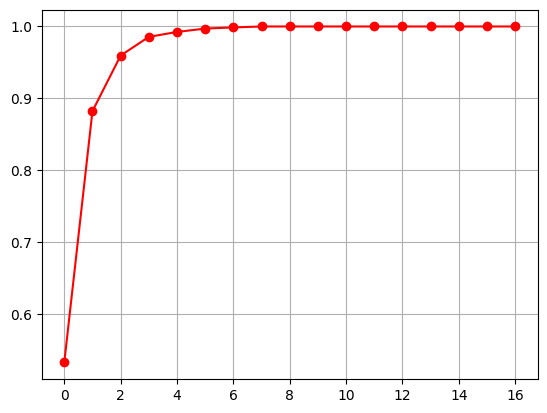

In [10]:
# Теперь, когда мы привели все данные к числовым значениям, можем воспользоваться методом главных компонент
# Это позволит снизить размерность обучающей выборки, и ускорить обучение
X_data = np.array(X_processed)
Y_data = np.array(Y_data)
pca = PCA()
x_pca = pca.fit_transform(X_data)
plt.plot(np.cumsum(pca.explained_variance_ratio_), 'ro-')
plt.grid()
plt.show()

In [11]:
pca_new = PCA(n_components=4)
x_new = pca_new.fit_transform(X_data)
x_train, x_test, y_train, y_test = train_test_split(x_new, Y_data, train_size=0.7)

In [12]:
# Попробуем использовать Градиентный бустинг. Он довольно хорошо справляется с данными, в которых много пробелов
# Так же он подходит для бинарной классификации, что в целом можно сказать про все алгоритмы ниже
clf = sklearn.ensemble.GradientBoostingClassifier()
clf.fit(x_train, y_train)

GradientBoostingClassifier()

In [20]:
y_train_pred = clf.predict(x_train)
y_test_pred = clf.predict(x_test)

ndcg = sklearn.metrics.ndcg_score([y_train_pred], [y_train], k= 20)
print("Train NDCG@k -score:", ndcg)
ndcg = sklearn.metrics.ndcg_score([y_test_pred], [y_test], k= 20)
print("Test NDCG@k -score:", ndcg)


Train NDCG@k -score: 0.9329443198318706
Test NDCG@k -score: 0.9325536323826256


In [16]:
# Попробуем так же метод опорных векторов, ему по идее тоже не особо критичны пробелы в данных, так как вектора с пробелами просто не будут опорными
# sv_machine = SVC(kernel='linear').fit(x_train,y_train)

In [17]:
# y_pred = sv_machine.predict(x_test)
# ndcg = sklearn.metrics.ndcg_score(y_true_sorted, y_test, k= 20)
# print("NDCG@k -score:", ndcg)


In [18]:
#Попробуем еще радномный лес. Он тоже должен хорошо рабоать с пробелами в данных.
rf = sklearn.ensemble.RandomForestClassifier(max_depth=32, random_state=0)
rf.fit(x_train, y_train)

RandomForestClassifier(max_depth=32, random_state=0)

In [21]:
y_train_pred = rf.predict(x_train)
y_test_pred = rf.predict(x_test)

ndcg = sklearn.metrics.ndcg_score([y_train_pred], [y_train], k= 20)
print("Train NDCG@k -score:", ndcg)
ndcg = sklearn.metrics.ndcg_score([y_test_pred], [y_test], k= 20)
print("Test NDCG@k -score:", ndcg)


Train NDCG@k -score: 0.988526190292789
Test NDCG@k -score: 0.7206985119067577


In [22]:
#Попоробуем логистическую регрессию
lr = sklearn.linear_model.LogisticRegression(max_iter=300,C=0.001,penalty="l2")
lr.fit(x_train,y_train)

LogisticRegression(C=0.001, max_iter=300)

In [23]:
y_train_pred = lr.predict(x_train)
y_test_pred = lr.predict(x_test)

ndcg = sklearn.metrics.ndcg_score([y_train_pred], [y_train], k= 20)
print("Train NDCG@k -score:", ndcg)
ndcg = sklearn.metrics.ndcg_score([y_test_pred], [y_test], k= 20)
print("Test NDCG@k -score:", ndcg)

Train NDCG@k -score: 0.5592436023163758
Test NDCG@k -score: 0.5585292086080057


Лучшим является алгоритм градиентного бустинга
